In [1]:
import os
import shutil
import numpy as np
import glob   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from matplotlib.pyplot import imshow
%matplotlib inline 

In [2]:
# Where all dataset is there
data_dir = 'C:/code/paddy-disease/training/PlantVillage'

# Training data dir
training_dir = 'C:/code/paddy-disease/training/Train'

# Test data dir
testing_dir = 'C:/code/paddy-disease/training/Test'

# Ratio of training and testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))
        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

  

        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [3]:
split_dataset_into_test_and_train_sets()

bacterial_leaf_blight has 438 images
brown_spot has 466 images
healthy has 464 images
leaf_blast has 454 images
leaf_scald has 448 images
narrow_brown_spot has 440 images
Processed 2167 training files.
Processed 543 testing files.


In [4]:
num_classes = 6

def get_model():
    base_model = VGG19(weights='imagenet', include_top=False)
 
    for layer in base_model.layers:
        layer.trainable = False
       
    base_model_ouput = base_model.output
   
    # Adding our own layer
    x = GlobalAveragePooling2D()(base_model_ouput)
    # Adding fully connected layer
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)
   
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [5]:
# Get the model
model = get_model()
# Compile it

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
# Summary of model
model.summary()


80134624/80134624 [==============================] - 33s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                             

In [6]:
# Number of classes in dataset
num_classes = 6
image_size=224
batch_size=32
# Get the model
model = get_model()

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=20)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_gen.flow_from_directory(training_dir,
                                                     target_size=(image_size, image_size),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

valid_generator = valid_data_gen.flow_from_directory(testing_dir,
                                                     target_size=(image_size, image_size),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

from sklearn.utils.class_weight import compute_class_weight

# Set up data generators with class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
# Set up callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.callbacks as callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
lr_schedule = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.2 ** epoch)

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Found 2167 images belonging to 6 classes.
Found 543 images belonging to 6 classes.
Epoch 1/30
68/68 [==============================] - 1072s 16s/step - loss: 0.7451 - accuracy: 0.7430 - precision: 0.7841 - recall: 0.7171 - auc: 0.9490 - val_loss: 0.4840 - val_accuracy: 0.8361 - val_precision: 0.8399 - val_recall: 0.8214 - val_auc: 0.9733 - lr: 0.0010
Epoch 2/30
68/68 [==============================] - 984s 14s/step - loss: 0.2628 - accuracy: 0.9012 - precision: 0.9124 - recall: 0.8842 - auc: 0.9919 - val_loss: 0.3420 - val_accuracy: 0.8766 - val_precision: 0.8908 - val_recall: 0.8711 - val_auc: 0.9868 - lr: 2.0000e-04
Epoch 3/30
68/68 [==============================] - 1726s 26s/step - loss: 0.2216 - accuracy: 0.9225 - precision: 0.9365 - recall: 0.9123 - auc: 0.9942 - val_loss: 0.3412 - val_accuracy: 0.8858 - val_precision: 0.8933 - val_recall: 0.8637 - val_auc: 0.9867 - lr: 4.0000e-05
Epoch 4/30
68/68 [==============================] - 1010s 15s/step - loss: 0.2212 - accuracy: 0.9225

In [7]:
# Unfreeze some layers in the pre-trained model
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model with fine-tuning
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=valid_generator,
                    callbacks=[early_stopping, reduce_lr, lr_schedule],
                    class_weight=class_weights)


Epoch 1/50
68/68 [==============================] - 1001s 15s/step - loss: 0.2008 - accuracy: 0.9331 - precision_1: 0.9438 - recall_1: 0.9225 - auc_1: 0.9957 - val_loss: 0.3345 - val_accuracy: 0.8840 - val_precision_1: 0.8935 - val_recall_1: 0.8656 - val_auc_1: 0.9871 - lr: 0.0010
Epoch 2/50
68/68 [==============================] - 983s 14s/step - loss: 0.2201 - accuracy: 0.9225 - precision_1: 0.9342 - recall_1: 0.9114 - auc_1: 0.9947 - val_loss: 0.3345 - val_accuracy: 0.8840 - val_precision_1: 0.8935 - val_recall_1: 0.8656 - val_auc_1: 0.9871 - lr: 2.0000e-04
Epoch 3/50
68/68 [==============================] - 993s 15s/step - loss: 0.2158 - accuracy: 0.9216 - precision_1: 0.9331 - recall_1: 0.9077 - auc_1: 0.9953 - val_loss: 0.3345 - val_accuracy: 0.8840 - val_precision_1: 0.8935 - val_recall_1: 0.8656 - val_auc_1: 0.9871 - lr: 4.0000e-05
Epoch 4/50
68/68 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9275 - precision_1: 0.9340 - recall_1: 0.9142 - auc_1: 0.99

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# Get the test data
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data_gen.flow_from_directory(testing_dir,
                                                   target_size=(image_size, image_size),
                                                   batch_size=batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical')

# Make predictions on the test data
y_pred = model.predict(test_generator)

# Get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true_labels = test_generator.classes

# Print the classification report and confusion matrix
print('Classification Report:')
print(classification_report(y_true_labels, y_pred_labels))
print('Confusion Matrix:')
print(confusion_matrix(y_true_labels, y_pred_labels))


Found 543 images belonging to 6 classes.
17/17 [==============================] - 187s 11s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        88
           1       0.77      0.83      0.80        93
           2       0.95      0.80      0.87        93
           3       0.73      0.79      0.76        91
           4       0.99      0.98      0.98        90
           5       0.92      0.98      0.95        88

    accuracy                           0.88       543
   macro avg       0.89      0.89      0.89       543
weighted avg       0.89      0.88      0.89       543

Confusion Matrix:
[[83  4  0  0  1  0]
 [ 0 77  2 11  0  3]
 [ 1  3 74 15  0  0]
 [ 1 14  2 72  0  2]
 [ 0  0  0  0 88  2]
 [ 0  2  0  0  0 86]]


In [9]:
history

In [10]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 68}

In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_auc_1', 'lr'])

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

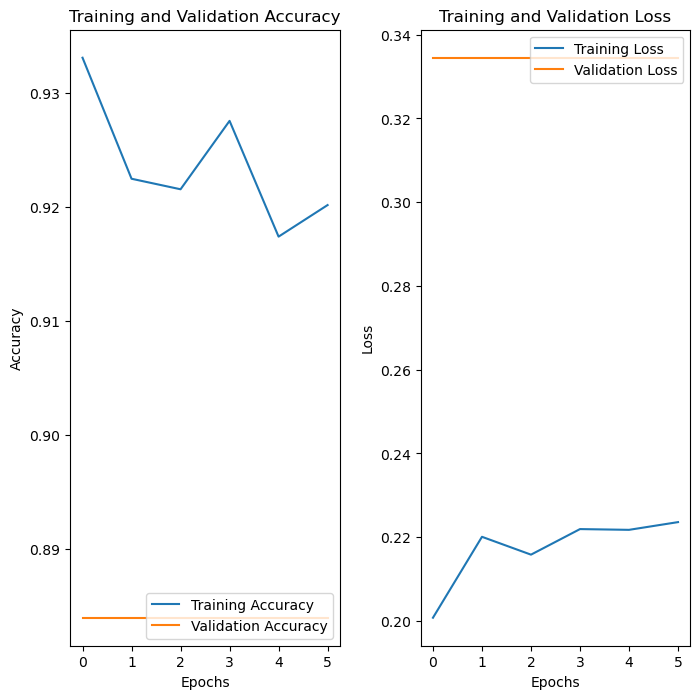

In [14]:
import matplotlib.pyplot as plt

epochs = 6

# create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# plot training and validation accuracy on first subplot
ax1.plot(range(epochs), acc, label='Training Accuracy')
ax1.plot(range(epochs), val_acc, label='Validation Accuracy')
ax1.legend(loc='lower right')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# plot training and validation loss on second subplot
ax2.plot(range(epochs), loss, label='Training Loss')
ax2.plot(range(epochs), val_loss, label='Validation Loss')
ax2.legend(loc='upper right')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

# add spacing between subplots
fig.subplots_adjust(wspace=0.3)

# show the plot
plt.show()

In [16]:
class_names=['bacterial_leaf_blight','brown_spot','healthy','leaf_blast','leaf_scald','narrow_brown_spot']
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 345ms/step


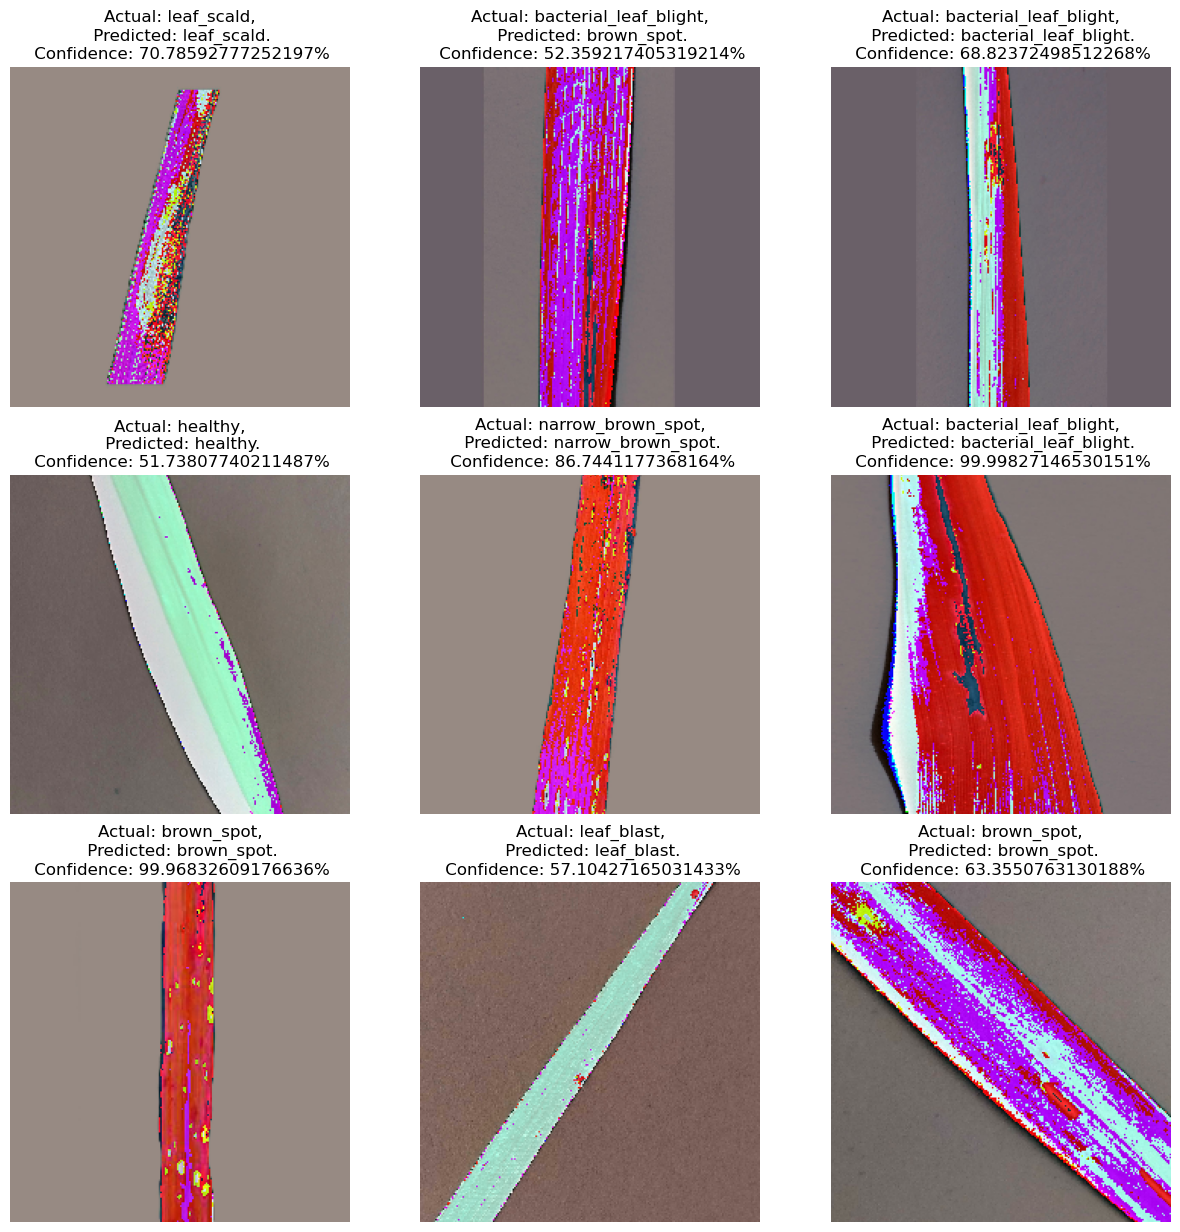

In [17]:
plt.figure(figsize=(15, 15))
images, labels = next(valid_generator)
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))

    predicted_class_probs = model.predict(np.expand_dims(images[i], axis=0))[0]
    predicted_class = class_names[np.argmax(predicted_class_probs)]
    confidence = predicted_class_probs[np.argmax(predicted_class_probs)] * 100
    actual_class = class_names[np.argmax(labels[i])]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")


In [18]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/3\assets


INFO:tensorflow:Assets written to: ../saved_models/3\assets


In [19]:
model.save("../paddyresnet101v2.h5")

In [20]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n\n\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

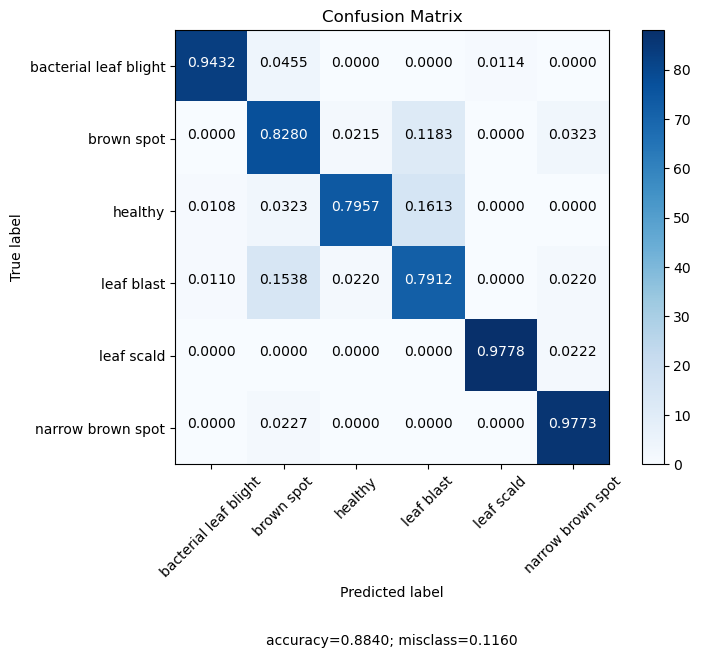

In [21]:
plot_confusion_matrix(cm           = np.array([[83,  4,  0,  0,  1,  0],
 [ 0, 77,  2, 11,  0,  3],
 [ 1,  3, 74, 15,  0,  0],
 [ 1, 14,  2, 72,  0,  2],
 [ 0,  0,  0,  0, 88,  2],
 [ 0,  2,  0,  0,  0, 86]]
), 
                      normalize    = True,
                      target_names = ['bacterial leaf blight', 'brown spot', 'healthy', 'leaf blast', 'leaf scald', 'narrow brown spot'],
                      title        = "Confusion Matrix")

In [22]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


INFO:tensorflow:Assets written to: ../saved_models/4\assets


In [23]:
model.save("../paddy.h5")